# 1. Getting Procedure Costs

# 1.1. Get the data

In this first step, we're going to use a custom library that contains the code for retrieving procedure costs from the Clear Health Costs website.  The `get_sleep_prices(zip, radius)` method collects prices for _sleep_ related procedures from a range around a particular zip code.  Each call to `get_sleep_prices()` retreives more data and stores it within the same `ClearHealthCosts` variable.  When we finish getting all the sleep data we want, it'll be all together in one place.

_NOTE: This may take a minute to run based on your internet connection.  If an asterix shows to the left of the code block (In [*]) that means that the code is running in the background.  Just wait._

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from GetPrices import ClearHealthCosts
import pandas as pd

chc = ClearHealthCosts()
chc.get_sleep_prices('10001',100) # New York
chc.get_sleep_prices('94016',100) # San Francisco
chc.get_sleep_prices('33018',100) # Miami
chc.get_sleep_prices('75001',100) # Dallas


## 1.2. Format the data

The `ClearHealthCosts` library can only output information as a simple nx6 matrix.  To do more interesting things with that data, we'll manually convert it to a Pandas dataframe.  From there, we can more easily compute and plot with this data.

In [3]:
df = pd.DataFrame.from_records(chc.prices())
df.columns = ['price','facility','address','condition','zip','radius']
df['city'] = df.zip.map({'10001':'New York', '94016':'San Francisco', '33018':'Miami', '75001':'Dallas'})
df.head()

,price,facility,address,condition,zip,radius,city
0,700.0,New York Sleep Disorder Center,"2951 Grand Concourse Ste. IA, Bronx NY",sleep,10001,100,New York
1,750.0,Sleep Center of Bucks County,"11 Friends Ln., Ste. 104, Newtown PA",sleep,10001,100,New York
2,800.0,Sleep Diagnostics of NY,"69-39 Yellowstone Blvd., Ste. #1, Forest Hills NY",sleep,10001,100,New York
3,878.0,NYU Langone Pulmonary and Sleep Medicine,"2408 Ocean Ave., Brooklyn NY",sleep,10001,100,New York
4,900.0,Aria Health Sleep Medicine,"Bustleton Ave. and Verree Rd., Philadelphia PA",sleep,10001,100,New York


In [4]:
df.to_excel('./facilities.xlsx')

## 1.3. Quick data profiling

Now that we've got the data stored in a way we can use it, we'll do some quick plots to see what these data look like.

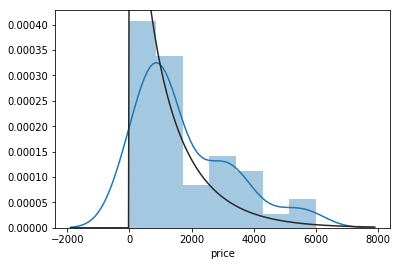

In [5]:
%matplotlib inline
import seaborn as sns
from scipy import stats, integrate

sns.distplot(df.price, fit=stats.gamma)

## 1.4 - Check for _bad data_

It looks like there might be a bunch of $0 entries that we'd want to exclude, so let's get rid of those.

In [6]:
total = len(df)
zeros = sum(df.price == 0)
print("{} out of {} have a  price of $0".format(zeros, total))

12 out of 83 have a  price of $0


In [7]:
df = df[df.price != 0]
df.head()

,price,facility,address,condition,zip,radius,city
0,700.0,New York Sleep Disorder Center,"2951 Grand Concourse Ste. IA, Bronx NY",sleep,10001,100,New York
1,750.0,Sleep Center of Bucks County,"11 Friends Ln., Ste. 104, Newtown PA",sleep,10001,100,New York
2,800.0,Sleep Diagnostics of NY,"69-39 Yellowstone Blvd., Ste. #1, Forest Hills NY",sleep,10001,100,New York
3,878.0,NYU Langone Pulmonary and Sleep Medicine,"2408 Ocean Ave., Brooklyn NY",sleep,10001,100,New York
4,900.0,Aria Health Sleep Medicine,"Bustleton Ave. and Verree Rd., Philadelphia PA",sleep,10001,100,New York


## 1.5 - Break things down

There's an interesting bubble there at $5,000 and a large skew at the low end of prices, so let's breakdown the data by which zip code we searched around.  That will show us if the bubble is specific to one region.

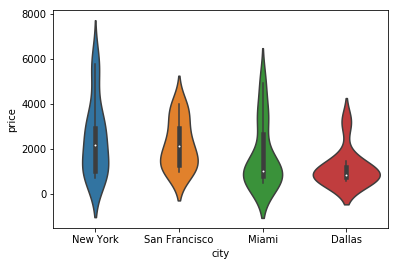

In [8]:
sns.violinplot(data=df, y='price', x='city')

# 2. Getting more information about these facilities

We've got some basic information about price distribution by region.  Their distributions are different, but all of them each have quite a reange of prices.  So, let's get some more information about these facilities to see if we can better understand the price distribution regardless of region.

## 2.1. Classifying the facilities

We could go out to all of these facilities' websites to find out if they were an inpatient department at a hospital or a stand-alone sleep clinic.  With so many to go through, we might need to try to automate this process, though.  One way to approach that is to use natural language processing to see if the facility name gives us any clue.  It may not be perfect, but might give us a reasonably good idea.

We've written a module called `ClassifyFacilities` that uses the **NLTK** library to tokenize and try to classify the facilities into a small set of groups.

In [9]:
from ClassifyFacilities import ClassifyFacilities
places = ['New','York','Miami','San','Francisco','Dallas',
          'NY','FL','Florida','CA','California','TX','Texas',
          'sleep','east','north','west','south']
num_clusters = 3

classifier = ClassifyFacilities()
classifier.classify(df.facility, places, num_clusters)

[nltk_data] Downloading package stopwords to /Users/paul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/paul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Below, you can see which key words were identified as the defining characteristics of each cluster and also which facilities are in each cluster.

In [10]:
classifier.print_clusters()

--------------------------------------------------------------------------------
0:diagnost,medicin,physician,hospit,institut,medic,intern,clinic,pulmonari,sleepm
--------------------------------------------------------------------------------
Sleep Diagnostics of NY,NYU Langone Pulmonary and Sleep Medicine,Lower Bucks Hospital,EOS Sleep Diagnostics,Sleep Disorders Institute,Sleep Medicine Associates of NYC,Bryn Mawr Hospital,Paoli Hospital for Sleep Medicine,Virtua Voorhees,Bay Sleep Clinic,North Coast Sleep Center - Santa Rosa,Santa Clara Valley Medical,SleepMed,Woodland Healthcare,Sleep Medicine Services,Virtual Imaging Miami, Hialeah Sleep Lab,Florida Sleep & Neuro Diagnostic Services Inc.,United Sleep Diagnostics Pembroke Pines,United Sleep Diagnostics Hollywood,Holy Cross Hospital,Pulmonary Physicians of South Florida, LLC,Sunrise Medical Group  Sleep Diagnostics,Choice Physicians of South Florida,International Institute of Sleep,International Institute-Sleep,Texas Medical Diagno

## 2.2. Label the clusters

Document clustering isn't smart enough, by itself, to put a meaningful human label on each grouping.  So, we're going to user our understanding of the context to interpret what each of the clusters mean based on the key words.

Having reviewed this, it looks like anything that's related to a sleep lab or physician clinic shows up in the group that includes _physician_ as one of the key words.  Everything else is probably a hospital.  We'll go through the clusters and assign a label for anything that includes _physician_ of **clinic** and **hospital** for everything else.

In [11]:
cluster_labels = classifier.get_cluster_names()
for num in cluster_labels:
    if 'physician' in cluster_labels[num]:
        cluster_labels[num] = 'clinic'
    else:
        cluster_labels[num] = 'hospital'
print(cluster_labels)

df['cluster'] = classifier.get_clusters()
df['facility_type'] = df.cluster.map(cluster_labels)

{0: 'clinic', 1: 'hospital', 2: 'hospital'}


## 2.3. Compare the distributions by label

Now that we've got the label attached to each of the facilities, let's do another distribution comparison based on teh type of facility.

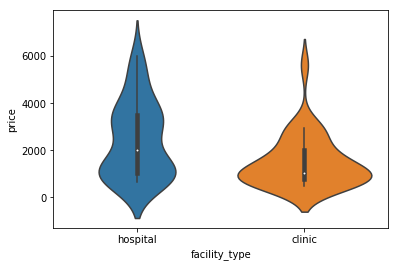

In [12]:
sns.violinplot(data=df, y='price', x='facility_type')

We should also review how big each of the facility_type categories are to make sure each represents a meaningful sample size.

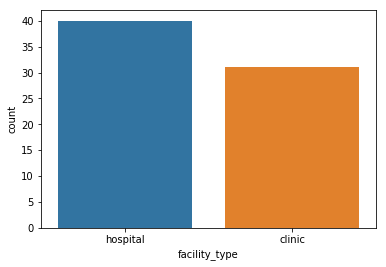

In [14]:
sns.countplot(data=df, x='facility_type')

Based on the even distribution between hospital and clinic facility types as well as the clear differnce in price distribution shapes, we can visually see there is likely to be some correlation between facility type and price.  Our hypothesis might be "clinic-based sleep centers are likely to cost less than hospital-based ones."

_I admit, we may have know that intuitively, but now we have some evidence to support our intuition.  That evidence can also now be part of a larger analysis rather than an arbitrary assumption that we cannot act on specifically._

# 3. Bring in external data

It's important to look at other external factors that might be correlated with the pricing.  Depending on what data we have access to, some of those might be proxy indicators, but they may be able to help us find a trend or cause.

In this case, since much of what we're doing is regional, we're going to look at the available demographics for that region.

# 4. Look at correlations

Finally, we're going to put it all together and see if we can't find some correlations that help us better understand the behavior and lead us closer to identifying potential causes for the extreme differences in cost.

# TODO

1. Make sure the clustering works
2. Bring in external data
3. Run some trends
